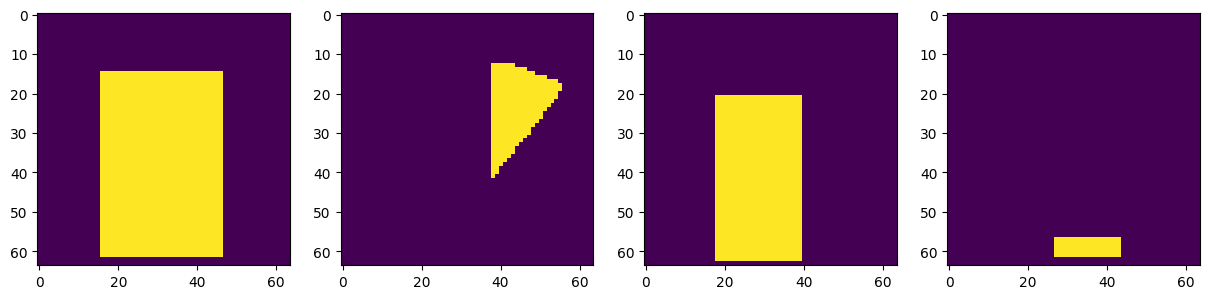

In [11]:
import numpy as np
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
# Set the number of images to generate
num_images = 1000

# Set the size of the images
image_size = 64

# Create an empty list to store the images and labels
data = []

# Generate the images and labels
for i in range(num_images):
    # Create a blank image
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)

    # Generate a random shape
    shape = np.random.randint(0, 3)
    if shape == 0:
        # Generate a circle
        center = (np.random.randint(0, image_size), np.random.randint(0, image_size))
        radius = np.random.randint(10, 20)
        color = (255, 255, 255)
        cv2.circle(image, center, radius, color, -1)
    elif shape == 1:
        # Generate a triangle
        pt1 = (np.random.randint(0, image_size), np.random.randint(0, image_size))
        pt2 = (np.random.randint(0, image_size), np.random.randint(0, image_size))
        pt3 = (np.random.randint(0, image_size), np.random.randint(0, image_size))
        color = (255, 255, 255)
        cv2.fillConvexPoly(image, np.array([pt1, pt2, pt3]), color)
    else:
        # Generate a rectangle
        pt1 = (np.random.randint(0, image_size), np.random.randint(0, image_size))
        pt2 = (np.random.randint(pt1[0], image_size), np.random.randint(pt1[1], image_size))
        color = (255, 255, 255)
        cv2.rectangle(image, pt1, pt2, color, -1)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Normalize the grayscale image
    gray_image = gray_image.astype("float32") / 255.0

    # Find the coordinates of the bounding box
    contours, hierarchy = cv2.findContours(gray_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    x_center = (x + w/2) / image_size
    y_center = (y + h/2) / image_size
    width = w / image_size
    height = h / image_size

    # Add the image and label to the list
    data.append((gray_image, (x_center, y_center, width, height)))

# Split the data into training and testing sets
train_data = data[:800]
test_data = data[800:]


# Visualize some samples
num_samples = 4
fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
for i in range(num_samples):
    image, label = train_data[i]
    x_center, y_center, width, height = label
    x = x_center * image_size
    y = y_center * image_size
    w = width * image_size
    h = height * image_size
    image_with_box = cv2.rectangle(image.copy(), (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), (0, 255, 0), 2)
    axes[i].imshow(image_with_box)
plt.show()


In [25]:

# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(8, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),

    layers.Dense(16, activation='relu'),
    layers.Dense(4)
])


# Compile the model
model.compile(optimizer='adam', loss='mse')
train_images = np.array([item[0] for item in train_data])
train_labels = np.array([item[1] for item in train_data])
test_images = np.array([item[0] for item in test_data])
test_labels = np.array([item[1] for item in test_data])

# Train the model
model.fit(train_images, train_labels, epochs=120, batch_size=16)

# Evaluate the model on the testing data
test_loss = model.evaluate(test_images, test_labels)
print('Test loss:', test_loss)


Epoch 1/120
50/50 [==============================] - 2s 4ms/step - loss: 0.0637
Epoch 2/120
50/50 [==============================] - 0s 4ms/step - loss: 0.0245
Epoch 3/120
50/50 [==============================] - 0s 4ms/step - loss: 0.0182
Epoch 4/120
50/50 [==============================] - 0s 4ms/step - loss: 0.0145
Epoch 5/120
50/50 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 6/120
50/50 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 7/120
50/50 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8/120
50/50 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 9/120
50/50 [==============================] - 0s 6ms/step - loss: 0.0074
Epoch 10/120
50/50 [==============================] - 0s 5ms/step - loss: 0.0071
Epoch 11/120
50/50 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 12/120
50/50 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 13/120
50/50 [=================

1/1 [==============================] - 0s 268ms/step


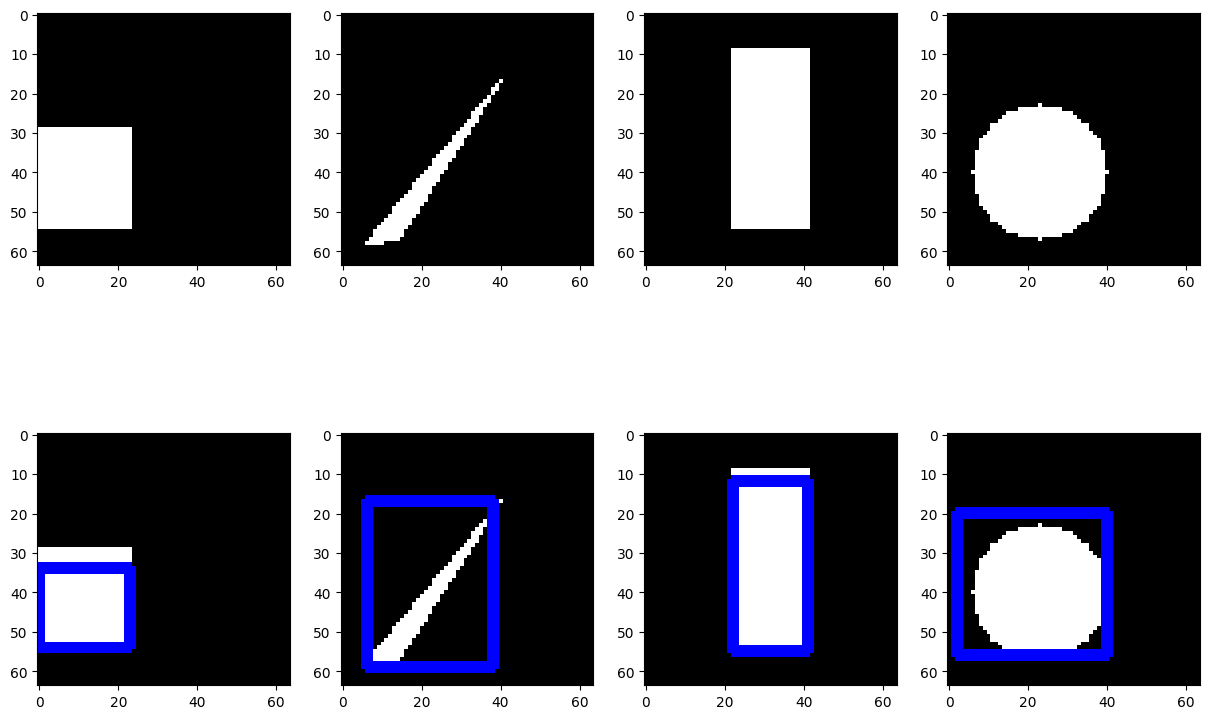

In [26]:
import matplotlib.pyplot as plt

# Choose some test images
num_test_images = 4
test_images = test_data[:num_test_images]

# Make predictions on the test images
test_images = np.array([item[0] for item in test_images])
test_labels = np.array([item[1] for item in test_data[:num_test_images]])
predictions = model.predict(test_images)

# Visualize the test images with ground truth and predicted bounding boxes
fig, axes = plt.subplots(2, num_test_images, figsize=(15, 10))
for i in range(num_test_images):
    # Plot the object alone
    object_image = test_images[i].copy()
    object_image = cv2.cvtColor(object_image, cv2.COLOR_GRAY2RGB)
    axes[0, i].imshow(object_image)

    # Plot the ground truth bounding box
    x_center_gt, y_center_gt, width_gt, height_gt = test_labels[i]
    x_gt = x_center_gt * image_size
    y_gt = y_center_gt * image_size
    w_gt = width_gt * image_size
    h_gt = height_gt * image_size
    image_with_gt_box = cv2.rectangle(object_image.copy(), (int(x_gt-w_gt/2), int(y_gt-h_gt/2)), (int(x_gt+w_gt/2), int(y_gt+h_gt/2)), (0, 255, 0), 2)
    axes[1, i].imshow(image_with_gt_box)

    # Plot the predicted bounding box
    x_center, y_center, width, height = predictions[i]
    x = x_center * image_size
    y = y_center * image_size
    w = width * image_size
    h = height * image_size
    image_with_box = cv2.rectangle(object_image.copy(), (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), (0, 0, 255), 2)
    axes[1, i].imshow(image_with_box)
plt.show()
